<a href="https://colab.research.google.com/github/kentokpara/COMP6999-001/blob/main/MRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Supervised Constrastive Learning**




In [1]:
#@title Import relevant modules
import numpy as np
import os
import PIL
import PIL.Image
!pip install tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import zipfile
from pathlib import Path
import glob
!pip install opencv-python
import cv2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
print(tf.__version__)

2.9.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/Trashnet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/Colab-Notebooks')
zip_ref.close()

In [5]:
base_dir = '/Colab-Notebooks/dataset-resized'


In [6]:
try:
   import splitfolders as sf
except ModuleNotFoundError:
  !pip install split-folders
  import splitfolders as sf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
input_folder = base_dir
output = '/Colab-Notebooks/Split'
 #where you want the split datasets saved
sf.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) 
# ratio of split are in order of train/val/ only.

base_dir = output

Copying files: 2527 files [00:00, 7583.64 files/s]


In [8]:
train_dataset = "/Colab-Notebooks/Split/train"
val_dataset = "/Colab-Notebooks/Split/val"


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=50,
    image_size=(180, 180),
)

Found 2019 files belonging to 6 classes.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dataset,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=50,
    image_size=(180, 180),
    shuffle=True,
)

Found 508 files belonging to 6 classes.


In [11]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


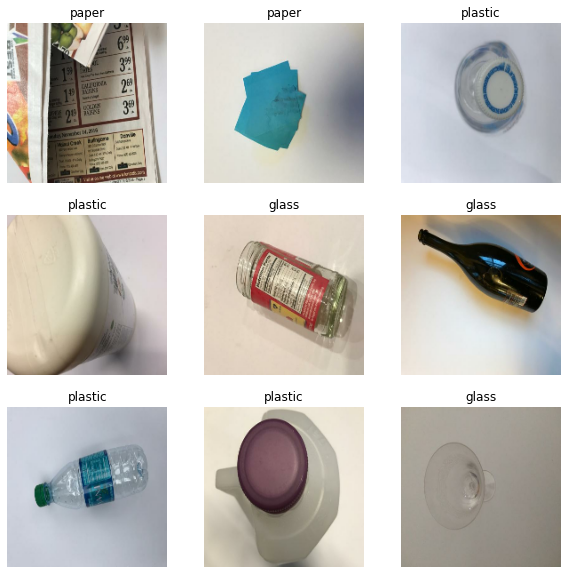

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 25.1 MB/s 


In [14]:
for images, labels in val_ds:
  x_test = images
  y_test = labels

print(x_test.shape)
print(y_test.shape)

(8, 180, 180, 3)
(8,)


In [15]:
for images, labels in train_ds:
  x_train = images
  y_train = labels

print(x_train.shape)
print(y_train.shape)

(19, 180, 180, 3)
(19,)


In [16]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomWidth(0.2),
        tf.keras.layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer

In [17]:
def create_encoder():
    Xcept = tf.keras.applications.Xception(
        include_top=False, weights=None, input_shape=(180,180,3), pooling="avg"
    )

    inputs = tf.keras.Input(shape=(180,180,3))
    augmented = data_augmentation(inputs)
    outputs = Xcept(augmented)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Xcept-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.0001
batch_size = 100
hidden_units = 2048
projection_units = 128
num_epochs = 40
dropout_rate = 0.4
temperature = 0.07

Model: "Xcept-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       7         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
Total params: 20,861,487
Trainable params: 20,806,952
Non-trainable params: 54,535
_________________________________________________________________


In [18]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = tf.keras.Input(shape=(180,180,3))
    features = encoder(inputs)
    features = tf.keras.layers.Dropout(dropout_rate)(features)
    features = tf.keras.layers.Dense(hidden_units, activation="relu")(features)
    features = tf.keras.layers.Dropout(dropout_rate)(features)
    outputs = tf.keras.layers.Dense(6, activation="softmax")(features)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Xcept-classifier")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [19]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)



Model: "Xcept-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 25,070,133
Trainable params: 25,015,

In [20]:
accuracy = classifier.evaluate(val_ds)[1]

print(f"Test accuracy: {round(accuracy * 100, 2)}%")

11/11 [==============================] - 1s 39ms/step - loss: 1.1656 - sparse_categorical_accuracy: 0.6929
Test accuracy: 69.29%


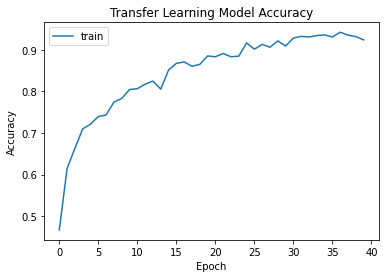

In [21]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

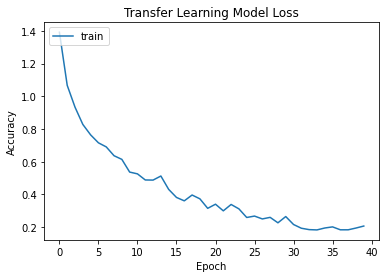

In [22]:
plt.plot(history.history['loss'])
plt.title('Transfer Learning Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [23]:
import tensorflow_addons as tfa

In [24]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = tf.keras.Input(shape=(180,180,3))
    features = encoder(inputs)
    outputs = tf.keras.layers.Dense(projection_units, activation="relu")(features)
    model = tf.keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection-head"
    )
    return model

In [25]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history1_Loss = encoder_with_projection_head.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
Total params: 21,123,759
Trainable params: 21,069,224
Non-trainable params: 54,535
_________________________________________________________________
Epoch 1/40
41/41 [==============================] - 23s 436ms/step - loss: 3.6481
Epoch 2/40
41/41 [==============================] - 15s 374ms/step - loss: 3.5134
Epoch 3/40
41/41 [==============================] - 16s 386ms/step - loss: 3.4125
Epoch 4/40
41/41 [=====================

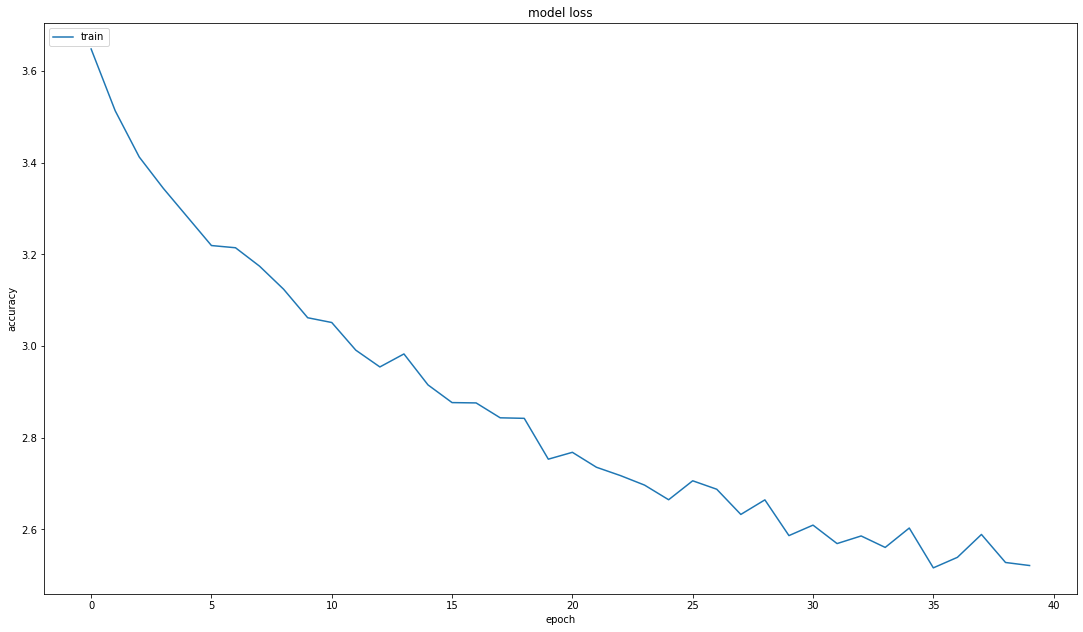

In [26]:
plt.plot(history1_Loss.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [27]:
classifier = create_classifier(encoder, trainable=False)

history1 = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/40
41/41 [==============================] - 6s 66ms/step - loss: 0.5681 - sparse_categorical_accuracy: 0.8212
Epoch 2/40
41/41 [==============================] - 3s 72ms/step - loss: 0.3029 - sparse_categorical_accuracy: 0.9148
Epoch 3/40
41/41 [==============================] - 3s 61ms/step - loss: 0.2664 - sparse_categorical_accuracy: 0.9168
Epoch 4/40
41/41 [==============================] - 3s 61ms/step - loss: 0.2509 - sparse_categorical_accuracy: 0.9212
Epoch 5/40
41/41 [==============================] - 3s 67ms/step - loss: 0.2360 - sparse_categorical_accuracy: 0.9242
Epoch 6/40
41/41 [==============================] - 3s 66ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9396
Epoch 7/40
41/41 [==============================] - 3s 75ms/step - loss: 0.2083 - sparse_categorical_accuracy: 0.9346
Epoch 8/40
41/41 [==============================] - 2s 57ms/step - loss: 0.2017 - sparse_categorical_accuracy: 0.9366
Epoch 9/40
41/41 [==============================] - 3s 6

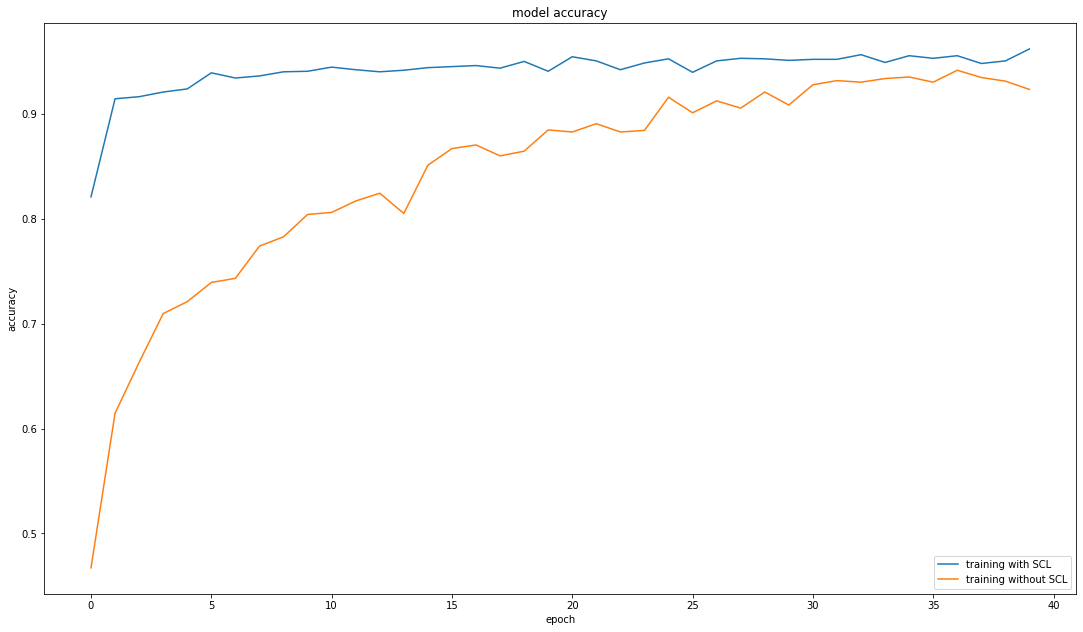

In [28]:
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training with SCL','training without SCL'], loc='lower right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [29]:
# Pillow
import PIL
from PIL import Image,ImageEnhance,ImageFilter

import numpy as np
import matplotlib.pyplot as plt
import glob, os
import re
import numpy
import pathlib as Path
import os.path
from os import path
import shutil
from random import randrange, uniform


In [30]:
shutil.rmtree('/Colab-Notebooks/Aug_Test/', ignore_errors=True)

In [31]:
if path.isdir('/Colab-Notebooks/Aug_Test/'):
  print('Path exists.....skipping')
else:
  os.mkdir('/Colab-Notebooks/Aug_Test/')

In [32]:
import cv2
import os
from PIL import ImageFilter

def load_images_from_folder(folder,class_names):
    global data
    data = []
    for subdir, dirs, files in os.walk(folder):
      for file in files:
        img = Image.open(os.path.join(subdir, file)).convert('RGB')
        img = img.resize((180, 180))
        #Random Generator
        x = uniform(0.2, 1.8)#where 0 is black and 2 is white
        #Preprocessing-Random Brightness
        color_enhancer = ImageEnhance.Brightness(img)
        img_EN = color_enhancer.enhance(x)

        #im_Ed = color_enhancer.enhance(.4)
        #data.extend([img_EN,im_Ed])
        open_cv_img = numpy.array(img)
        open_cv_img_en = numpy.array(img_EN)
        #open_cv_img_ed = numpy.array(im_Ed)
        open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)
        open_cv_img_en = cv2.cvtColor(open_cv_img_en, cv2.COLOR_RGB2BGR)
        #open_cv_img_ed = cv2.cvtColor(open_cv_img_ed, cv2.COLOR_RGB2BGR)
        data.extend([open_cv_img,open_cv_img_en])
          # Convert RGB to BGR 
        for a in range (0,(len(data))):
            #data[a].save(save_path /  str(count)+'.jpg')
            #path = os.path.join('/Colab-Notebooks/Aug_Test/',class_names)
            base_path = '/Colab-Notebooks/Aug_Test/'
            if path.isdir(os.path.join(base_path,class_names)):
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            else:
              os.mkdir(os.path.join(base_path,class_names))
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            #print(path + f'/image_{a}.png')
            #cv2.imwrite(f'/Colab-Notebooks/Test3/image_{a}.png',data[a])

    return

In [33]:
 #data.extend([img_EN,im_Ed])
       

In [34]:
#@title Default title text
load_images_from_folder("/Colab-Notebooks/Split/train/cardboard",'cardboard')


In [35]:
load_images_from_folder("/Colab-Notebooks/Split/train/glass",'glass')

In [36]:
load_images_from_folder("/Colab-Notebooks/Split/train/metal",'metal')

In [37]:
load_images_from_folder("/Colab-Notebooks/Split/train/paper",'paper')


In [38]:
load_images_from_folder("/Colab-Notebooks/Split/train/trash",'trash')


In [39]:
load_images_from_folder("/Colab-Notebooks/Split/train/plastic",'plastic')

In [40]:
Test = '/Colab-Notebooks/Aug_Test/'

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    Test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    image_size=(180,180),
    batch_size=32,
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4038 files belonging to 6 classes.


In [42]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history_mod_loss = encoder_with_projection_head.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dense_5 (Dense)             (None, 128)               262272    
                                                                 
Total params: 21,123,759
Trainable params: 21,069,224
Non-trainable params: 54,535
_________________________________________________________________
Epoch 1/40
127/127 [==============================] - 76s 562ms/step - loss: 3.2128
Epoch 2/40
127/127 [==============================] - 58s 456ms/step - loss: 3.1079
Epoch 3/40
127/127 [==============================] - 51s 398ms/step - loss: 3.0532
Epoch 4/40
127/127 [=============

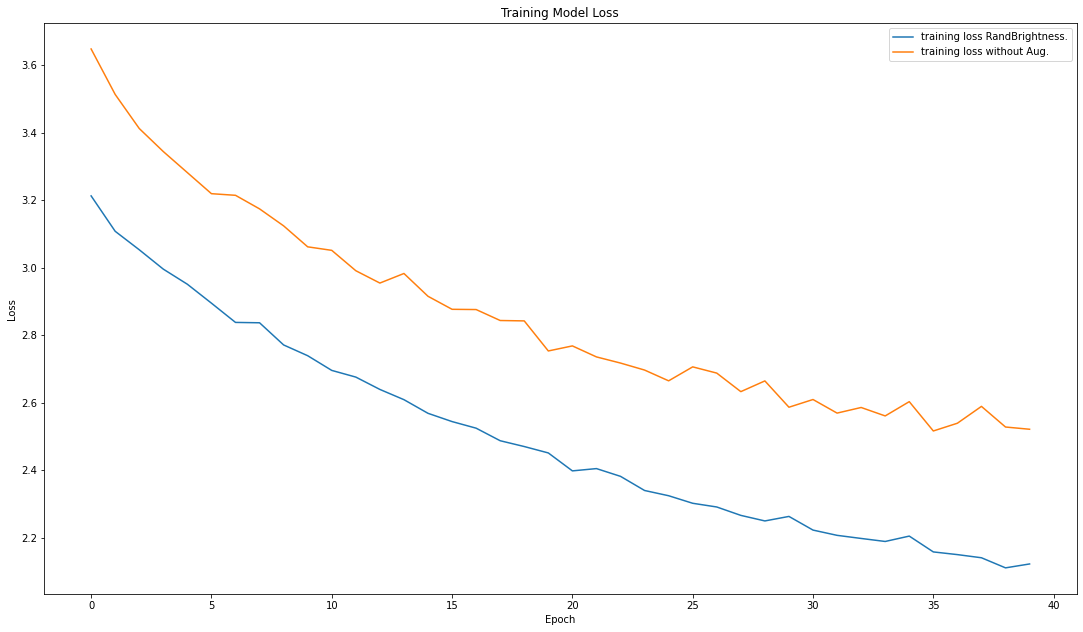

In [43]:
plt.plot(history_mod_loss.history['loss'])
plt.plot(history1_Loss.history['loss'])
#plt.plot(history1.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss RandBrightness.','training loss without Aug.' ], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [44]:
classifier = create_classifier(encoder, trainable=False)

history_mod = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/40
127/127 [==============================] - 8s 39ms/step - loss: 0.3338 - sparse_categorical_accuracy: 0.8985
Epoch 2/40
127/127 [==============================] - 5s 39ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9324
Epoch 3/40
127/127 [==============================] - 5s 39ms/step - loss: 0.1833 - sparse_categorical_accuracy: 0.9368
Epoch 4/40
127/127 [==============================] - 5s 38ms/step - loss: 0.1700 - sparse_categorical_accuracy: 0.9433
Epoch 5/40
127/127 [==============================] - 5s 41ms/step - loss: 0.1806 - sparse_categorical_accuracy: 0.9341
Epoch 6/40
127/127 [==============================] - 5s 39ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.9510
Epoch 7/40
127/127 [==============================] - 5s 39ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.9525
Epoch 8/40
127/127 [==============================] - 5s 38ms/step - loss: 0.1494 - sparse_categorical_accuracy: 0.9480
Epoch 9/40
127/127 [====================

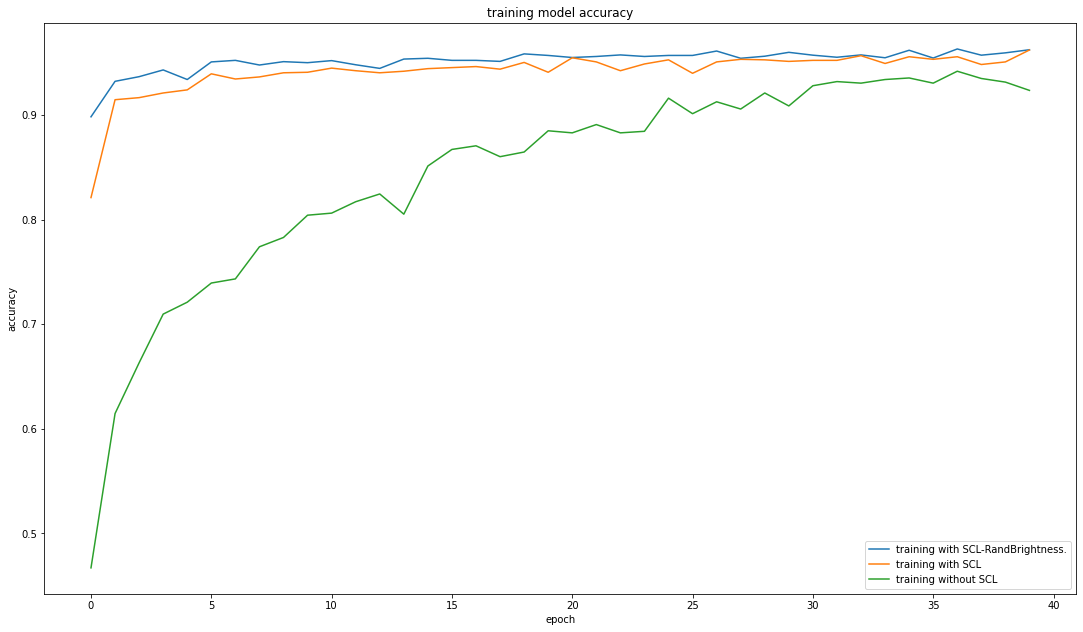

In [45]:
plt.plot(history_mod.history['sparse_categorical_accuracy'])
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('training model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training with SCL-RandBrightness.','training with SCL','training without SCL'], loc='lower right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

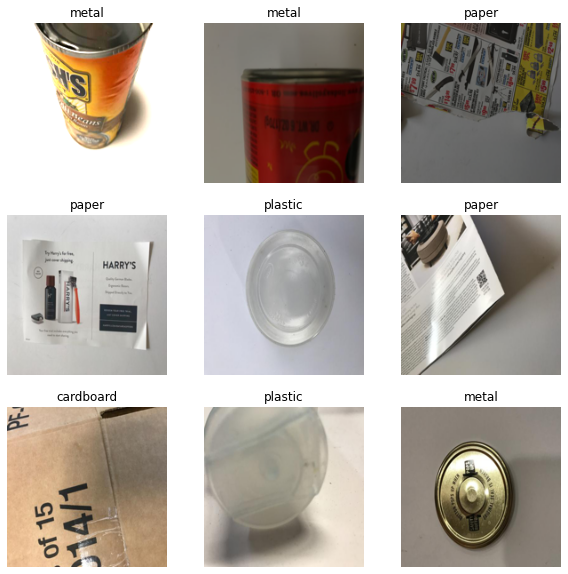

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [47]:
shutil.rmtree('/Colab-Notebooks/Augc_Test/', ignore_errors=True)

In [48]:
if path.isdir('/Colab-Notebooks/Augc_Test/'):
  print('Path exists.....skipping')
else:
  os.mkdir('/Colab-Notebooks/Augc_Test/')

In [49]:
import cv2
import os
from PIL import ImageFilter

def load_images_from_folder(folder,class_names):
    global data
    data = []
    for subdir, dirs, files in os.walk(folder):
      for file in files:
        img = Image.open(os.path.join(subdir, file)).convert('RGB')
        img = img.resize((180, 180))
        #Random Generator
        x = uniform(0.0, 1.0)
        #Preprocessing-Random Contrast
        color_enhancer = ImageEnhance.Contrast(img)
        img_EN = color_enhancer.enhance(x)

        #im_Ed = color_enhancer.enhance(.4)
        #data.extend([img_EN,im_Ed])
        open_cv_img = numpy.array(img)
        open_cv_img_en = numpy.array(img_EN)
        #open_cv_img_ed = numpy.array(im_Ed)
        open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)
        open_cv_img_en = cv2.cvtColor(open_cv_img_en, cv2.COLOR_RGB2BGR)
        #open_cv_img_ed = cv2.cvtColor(open_cv_img_ed, cv2.COLOR_RGB2BGR)
        data.extend([open_cv_img,open_cv_img_en])
          # Convert RGB to BGR 
        for a in range (0,(len(data))):
            #data[a].save(save_path /  str(count)+'.jpg')
            #path = os.path.join('/Colab-Notebooks/Aug_Test/',class_names)
            base_path = '/Colab-Notebooks/Augc_Test/'
            if path.isdir(os.path.join(base_path,class_names)):
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            else:
              os.mkdir(os.path.join(base_path,class_names))
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            #print(path + f'/image_{a}.png')
            #cv2.imwrite(f'/Colab-Notebooks/Test3/image_{a}.png',data[a])

    return

In [50]:
load_images_from_folder("/Colab-Notebooks/Split/train/cardboard",'cardboard')
load_images_from_folder("/Colab-Notebooks/Split/train/glass",'glass')
load_images_from_folder("/Colab-Notebooks/Split/train/metal",'metal')
load_images_from_folder("/Colab-Notebooks/Split/train/paper",'paper')
load_images_from_folder("/Colab-Notebooks/Split/train/trash",'trash')
load_images_from_folder("/Colab-Notebooks/Split/train/plastic",'plastic')


In [51]:
Test1 = '/Colab-Notebooks/Augc_Test/'

In [52]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    Test1,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    image_size=(180,180),
    batch_size=32,
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4038 files belonging to 6 classes.


In [53]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history_mod_loss1 = encoder_with_projection_head.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
Total params: 21,123,759
Trainable params: 21,069,224
Non-trainable params: 54,535
_________________________________________________________________
Epoch 1/40
127/127 [==============================] - 30s 204ms/step - loss: 3.2357
Epoch 2/40
127/127 [==============================] - 28s 220ms/step - loss: 3.1236
Epoch 3/40
127/127 [==============================] - 28s 217ms/step - loss: 3.0642
Epoch 4/40
127/127 [=============

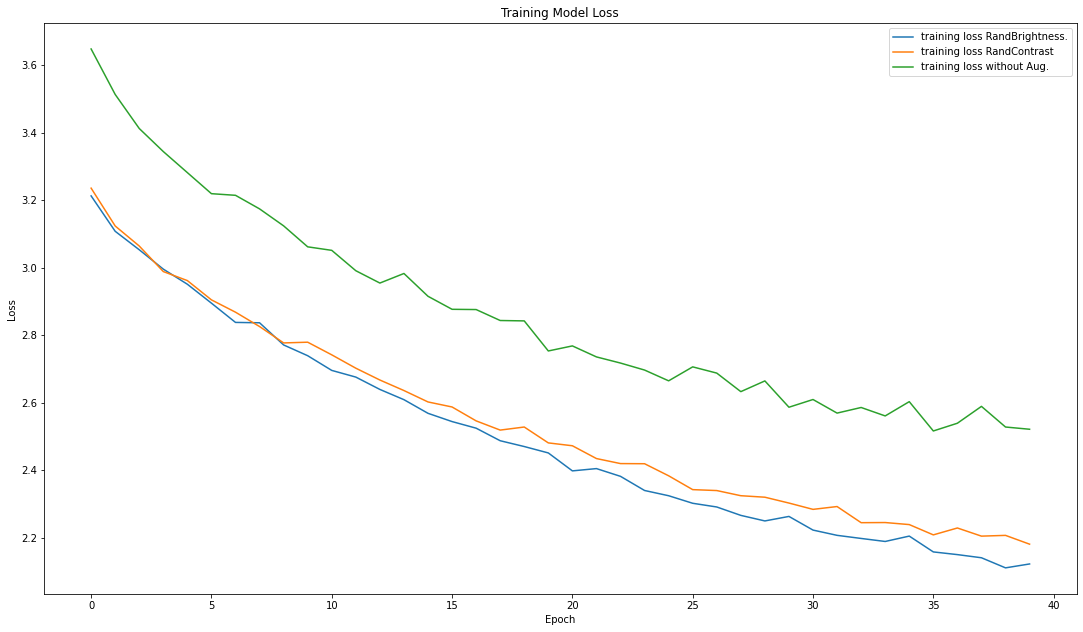

In [54]:
plt.plot(history_mod_loss.history['loss'])
plt.plot(history_mod_loss1.history['loss'])
plt.plot(history1_Loss.history['loss'])
#plt.plot(history1.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss RandBrightness.','training loss RandContrast','training loss without Aug.' ], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [55]:
classifier = create_classifier(encoder, trainable=False)

history_mod1 = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/40
127/127 [==============================] - 7s 36ms/step - loss: 0.4086 - sparse_categorical_accuracy: 0.8700
Epoch 2/40
127/127 [==============================] - 5s 36ms/step - loss: 0.2777 - sparse_categorical_accuracy: 0.9111
Epoch 3/40
127/127 [==============================] - 5s 36ms/step - loss: 0.2609 - sparse_categorical_accuracy: 0.9091
Epoch 4/40
127/127 [==============================] - 5s 35ms/step - loss: 0.2569 - sparse_categorical_accuracy: 0.9163
Epoch 5/40
127/127 [==============================] - 5s 35ms/step - loss: 0.2526 - sparse_categorical_accuracy: 0.9188
Epoch 6/40
127/127 [==============================] - 5s 36ms/step - loss: 0.2445 - sparse_categorical_accuracy: 0.9170
Epoch 7/40
127/127 [==============================] - 5s 37ms/step - loss: 0.2373 - sparse_categorical_accuracy: 0.9227
Epoch 8/40
127/127 [==============================] - 5s 36ms/step - loss: 0.2333 - sparse_categorical_accuracy: 0.9188
Epoch 9/40
127/127 [====================

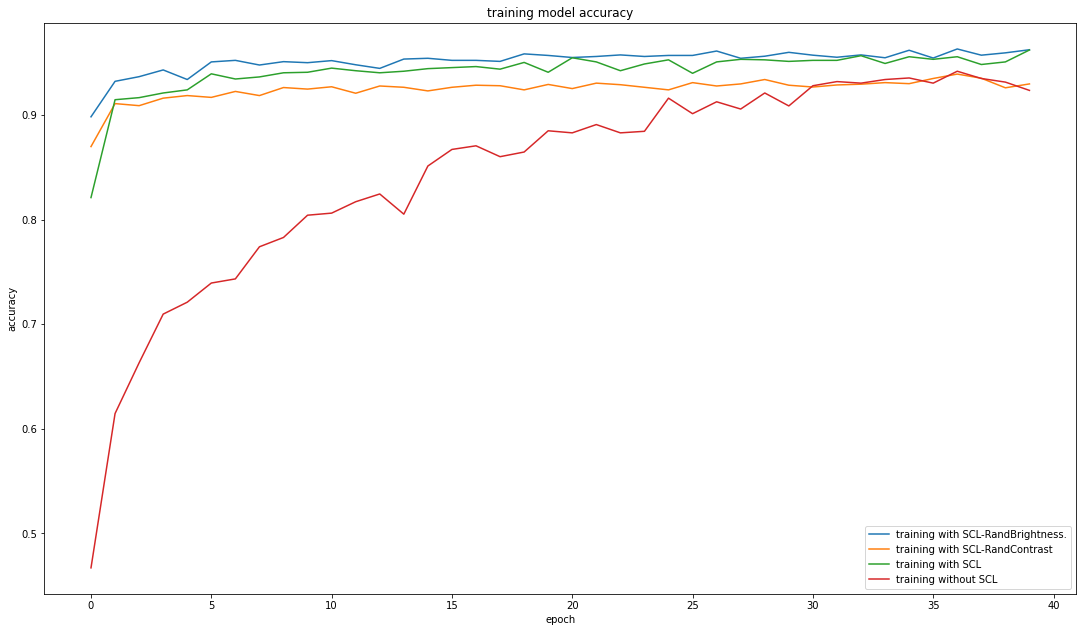

In [56]:
plt.plot(history_mod.history['sparse_categorical_accuracy'])
plt.plot(history_mod1.history['sparse_categorical_accuracy'])
#plt.plot(history_mod2.history['sparse_categorical_accuracy'])
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('training model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training with SCL-RandBrightness.','training with SCL-RandContrast','training with SCL','training without SCL'], loc='lower right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

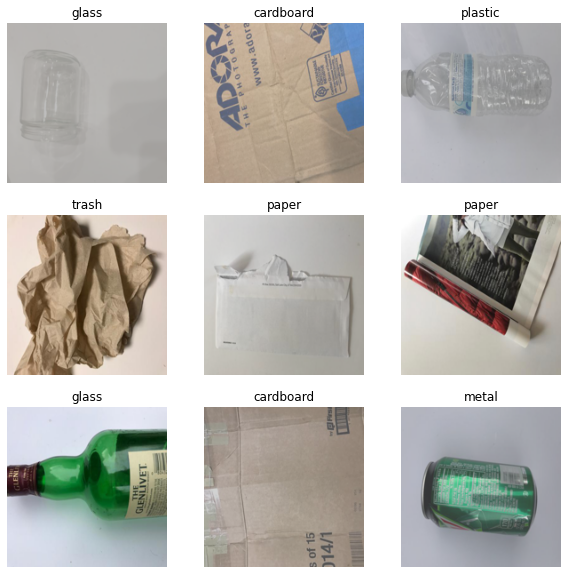

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

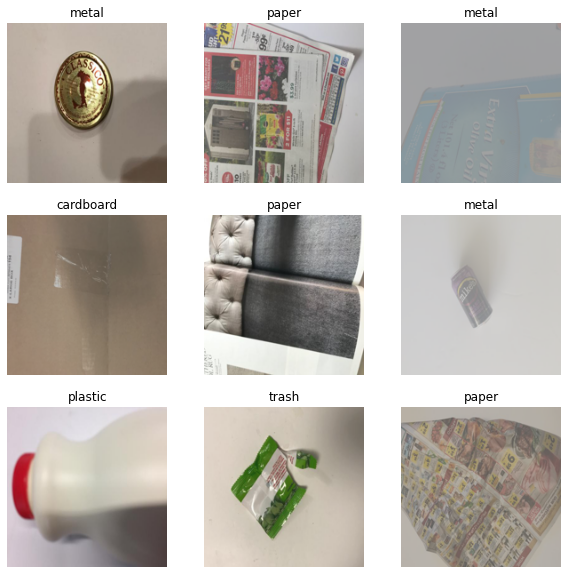

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [59]:
shutil.rmtree('/Colab-Notebooks/Augb_Test/', ignore_errors=True)

In [60]:
if path.isdir('/Colab-Notebooks/Augb_Test/'):
  print('Path exists.....skipping')
else:
  os.mkdir('/Colab-Notebooks/Augb_Test/')

In [61]:
import cv2
import os
from PIL import ImageFilter

def load_images_from_folder(folder,class_names):
    global data
    data = []
    for subdir, dirs, files in os.walk(folder):
      for file in files:
        img = Image.open(os.path.join(subdir, file)).convert('RGB')
        img = img.resize((180, 180))
        #Random Generator
        x = uniform(0.0, 2.0)
        #Preprocessing-Random Contrast
        color_enhancer = ImageEnhance.Sharpness(img)
        img_EN = color_enhancer.enhance(x)

        #im_Ed = color_enhancer.enhance(.4)
        #data.extend([img_EN,im_Ed])
        open_cv_img = numpy.array(img)
        open_cv_img_en = numpy.array(img_EN)
        #open_cv_img_ed = numpy.array(im_Ed)
        open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)
        open_cv_img_en = cv2.cvtColor(open_cv_img_en, cv2.COLOR_RGB2BGR)
        #open_cv_img_ed = cv2.cvtColor(open_cv_img_ed, cv2.COLOR_RGB2BGR)
        data.extend([open_cv_img,open_cv_img_en])
          # Convert RGB to BGR 
        for a in range (0,(len(data))):
            #data[a].save(save_path /  str(count)+'.jpg')
            #path = os.path.join('/Colab-Notebooks/Aug_Test/',class_names)
            base_path = '/Colab-Notebooks/Augb_Test/'
            if path.isdir(os.path.join(base_path,class_names)):
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            else:
              os.mkdir(os.path.join(base_path,class_names))
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            #print(path + f'/image_{a}.png')
            #cv2.imwrite(f'/Colab-Notebooks/Test3/image_{a}.png',data[a])

    return

In [ ]:
load_images_from_folder("/Colab-Notebooks/Split/train/cardboard",'cardboard')
load_images_from_folder("/Colab-Notebooks/Split/train/glass",'glass')
load_images_from_folder("/Colab-Notebooks/Split/train/metal",'metal')
load_images_from_folder("/Colab-Notebooks/Split/train/paper",'paper')
load_images_from_folder("/Colab-Notebooks/Split/train/trash",'trash')
load_images_from_folder("/Colab-Notebooks/Split/train/plastic",'plastic')

In [ ]:
Test2 = '/Colab-Notebooks/Augb_Test/'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    Test2,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    image_size=(180,180),
    batch_size=32,
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,)

In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history_mod_loss2 = encoder_with_projection_head.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

In [ ]:
plt.plot(history_mod_loss.history['loss'])
plt.plot(history_mod_loss1.history['loss'])
plt.plot(history_mod_loss2.history['loss'])
plt.plot(history1_Loss.history['loss'])
#plt.plot(history1.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss RandBrightness','training loss RandContrast','training loss RandSharpness','training loss without Aug.' ], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history_mod2 = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
plt.plot(history_mod.history['sparse_categorical_accuracy'])
plt.plot(history_mod1.history['sparse_categorical_accuracy'])
plt.plot(history_mod2.history['sparse_categorical_accuracy'])
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('training model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training with SCL-RandBrightness.','training with SCL-RandContrast','training with SCL-RandSharpness','training with SCL','training without SCL'], loc='lower right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")